In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import zipfile
import pathlib

import numpy as np
import tensorflow as tf


from matplotlib import pyplot as plt

In [3]:
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.15.0


In [4]:
zip_file_path = '/content/drive/MyDrive/furniture-dataset.zip'
colab_zip_path = '/content/furniture-dataset.zip'
shutil.copy(zip_file_path, colab_zip_path)

'/content/furniture-dataset.zip'

In [5]:
local_zip = '/content/furniture-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [6]:
PATH = '/content/furniture-dataset'
PATH

'/content/furniture-dataset'

In [7]:
data_dir = pathlib.Path(PATH)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total image from this datasets : {image_count}')

print(f'\nDistribution Image')
for i, label in enumerate(os.listdir(data_dir)):
  label_dir = os.path.join(data_dir, label)
  len_label_dir = len(os.listdir(label_dir))
  print(f'{i+1}. {label} : {len_label_dir}')

Total image from this datasets : 1744

Distribution Image
1. ranjang : 670
2. lemari : 670
3. meja : 670
4. kursi : 670


In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

np.random.seed(123)
seed = np.random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 66


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2680 files belonging to 4 classes.
Using 2144 files for training.
Found 2680 files belonging to 4 classes.
Using 536 files for validation.


In [10]:
class_names = train_ds.class_names
class_names_val = val_ds.class_names

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

List label Train data: 
['kursi', 'lemari', 'meja', 'ranjang']

List label Validation data: 
['kursi', 'lemari', 'meja', 'ranjang']


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


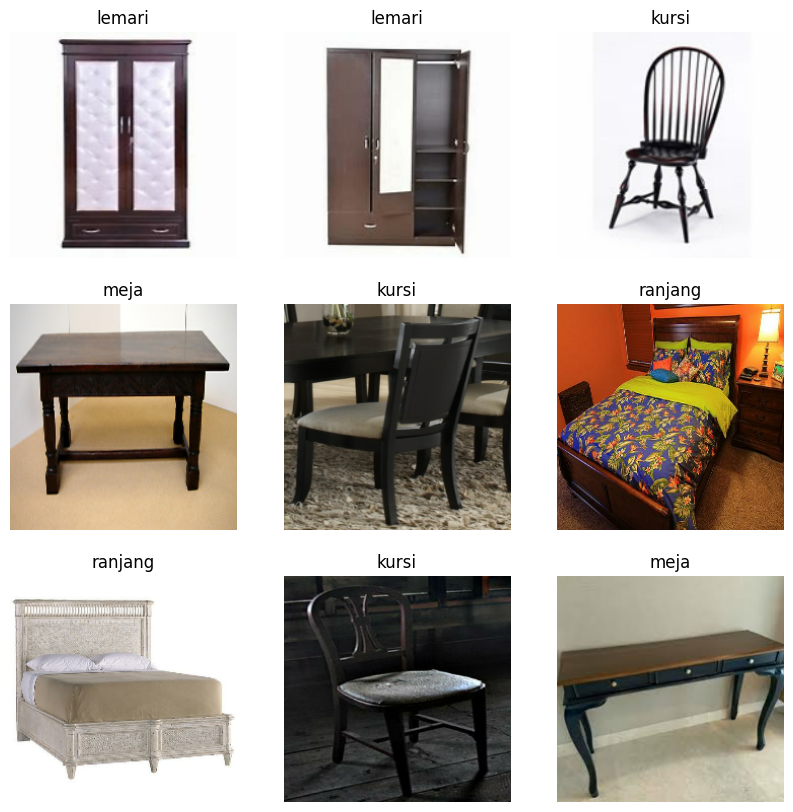

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 14
Number of test batches: 3


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(image_count//4).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  # tf.keras.layers.RandomZoom(0.2)],
  tf.keras.layers.RandomZoom(0.1)],
  name="data_augmentation")

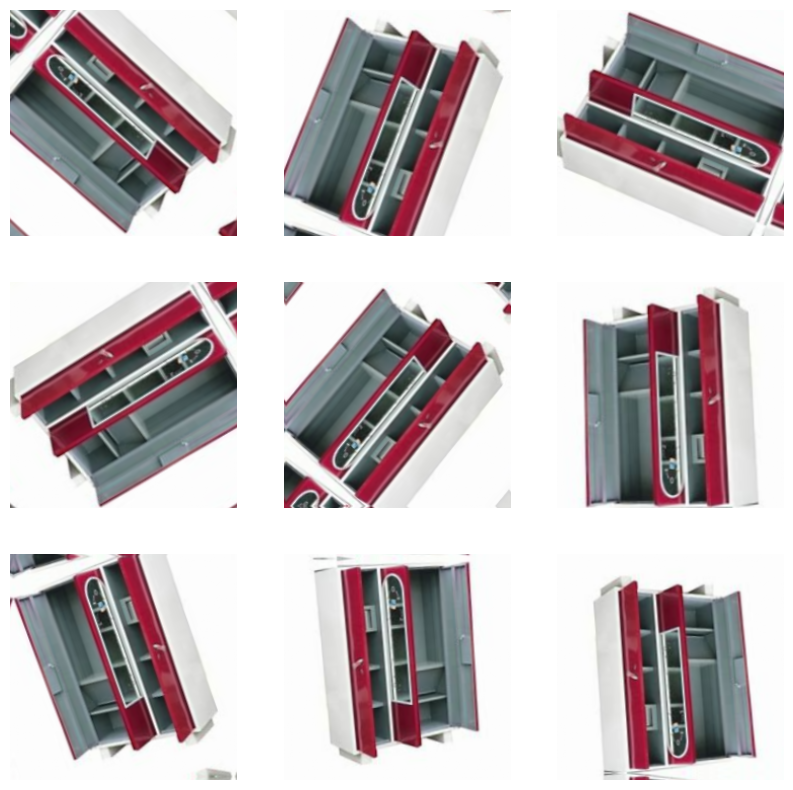

In [16]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [20]:
base_model.trainable = False

In [21]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

In [22]:
def model_builder():

  # Number Classes from data
  num_classes = len(class_names)

  # Create Model Sequential keras
  model = tf.keras.Sequential()

  # Add Custom Layer
  model.add(inputs)
  model.add(data_augmentation)
  model.add(normalization_layer)
  model.add(base_model)
  model.add(global_average_layer)

  # Add fully connected layer with dropout
  model.add(tf.keras.layers.Dense(units=512, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))

  # Prediction Layer
  model.add(tf.keras.layers.Dense(num_classes,
                                  activation='softmax',
                                  name="final_output"))

  base_learning_rate = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

In [23]:

model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5",
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10,
                                                  mode ="max",
                                                  verbose=2,
                                                  restore_best_weights=True)

In [24]:
model = model_builder()
print(f"Model : {model}")

Model : <keras.src.engine.sequential.Sequential object at 0x7a6cdff26a40>


In [25]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.8181
Epoch 1: val_accuracy improved from -inf to 0.95909, saving model to checkpoint_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - 14s 92ms/step - loss: 0.4950 - accuracy: 0.8181 - val_loss: 0.1314 - val_accuracy: 0.9591
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8811
Epoch 2: val_accuracy did not improve from 0.95909
67/67 [==============================] - 3s 51ms/step - loss: 0.2932 - accuracy: 0.8811 - val_loss: 0.1406 - val_accuracy: 0.9545
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.2313 - accuracy: 0.9188
Epoch 3: val_accuracy improved from 0.95909 to 0.97045, saving model to checkpoint_model.h5
67/67 [==============================] - 4s 57ms/step - loss: 0.2313 - accuracy: 0.9188 - val_loss: 0.1055 - val_accuracy: 0.9705
Epoch 4/100
66/67 [============================>.] - ETA: 0s - loss: 0.1990 - accuracy: 0.9238
Epoch 4: val_accuracy did not improve from 0.97045
67/67 [==============================] - 3s 51ms/step - loss: 0.2011 - accuracy: 0.9230 - val_loss: 0.0851 - val_accuracy: 0.9682


In [26]:
%matplotlib inline
plt.style.use('seaborn')

<ipython-input-26-447fa776aed2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


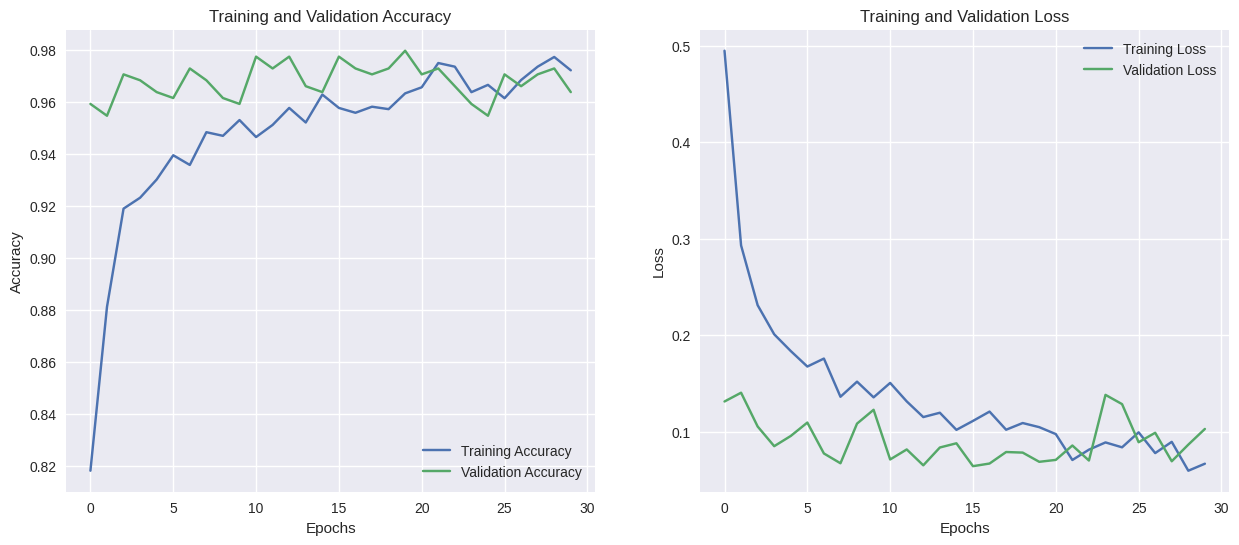

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [28]:
load_model = tf.keras.models.load_model('checkpoint_model.h5')
load_model.evaluate(x=test_dataset, return_dict=True)

3/3 [==============================] - 1s 63ms/step - loss: 0.1038 - accuracy: 0.9792


{'loss': 0.10383329540491104, 'accuracy': 0.9791666865348816}

In [29]:
class_names = np.array(class_names)
class_names_val = np.array(class_names_val)

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

List label Train data: 
['kursi' 'lemari' 'meja' 'ranjang']

List label Validation data: 
['kursi' 'lemari' 'meja' 'ranjang']


In [30]:
image_batch_test, label_batch_test = next(iter(test_dataset))

image_batch_test, label_batch_test = image_batch_test.numpy(), label_batch_test.numpy()


predicted_batch = load_model.predict(image_batch_test)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 1s 1s/step
['meja' 'ranjang' 'kursi' 'lemari' 'ranjang' 'meja' 'lemari' 'lemari'
 'meja' 'kursi' 'meja' 'meja' 'ranjang' 'lemari' 'ranjang' 'meja' 'kursi'
 'meja' 'lemari' 'meja' 'lemari' 'meja' 'meja' 'kursi' 'ranjang' 'ranjang'
 'kursi' 'ranjang' 'kursi' 'kursi' 'lemari' 'kursi']


In [31]:
print(f"Labels:\n{label_batch_test}")
print(f"Predicted labels:\n{predicted_ids}")

true_predict = 0
false_predict = 0

for i in predicted_ids:
  if i in label_batch_test:
    true_predict +=1
  else:
    false_predict +=1

print()
print(f'True Predict Count : {true_predict}')
print(f'False Predict Count : {false_predict}')

Labels:
[2 3 0 1 3 2 1 1 2 0 2 2 3 1 3 2 0 2 1 2 1 2 2 0 3 3 0 3 0 0 1 0]
Predicted labels:
[2 3 0 1 3 2 1 1 2 0 2 2 3 1 3 2 0 2 1 2 1 2 2 0 3 3 0 3 0 0 1 0]

True Predict Count : 32
False Predict Count : 0


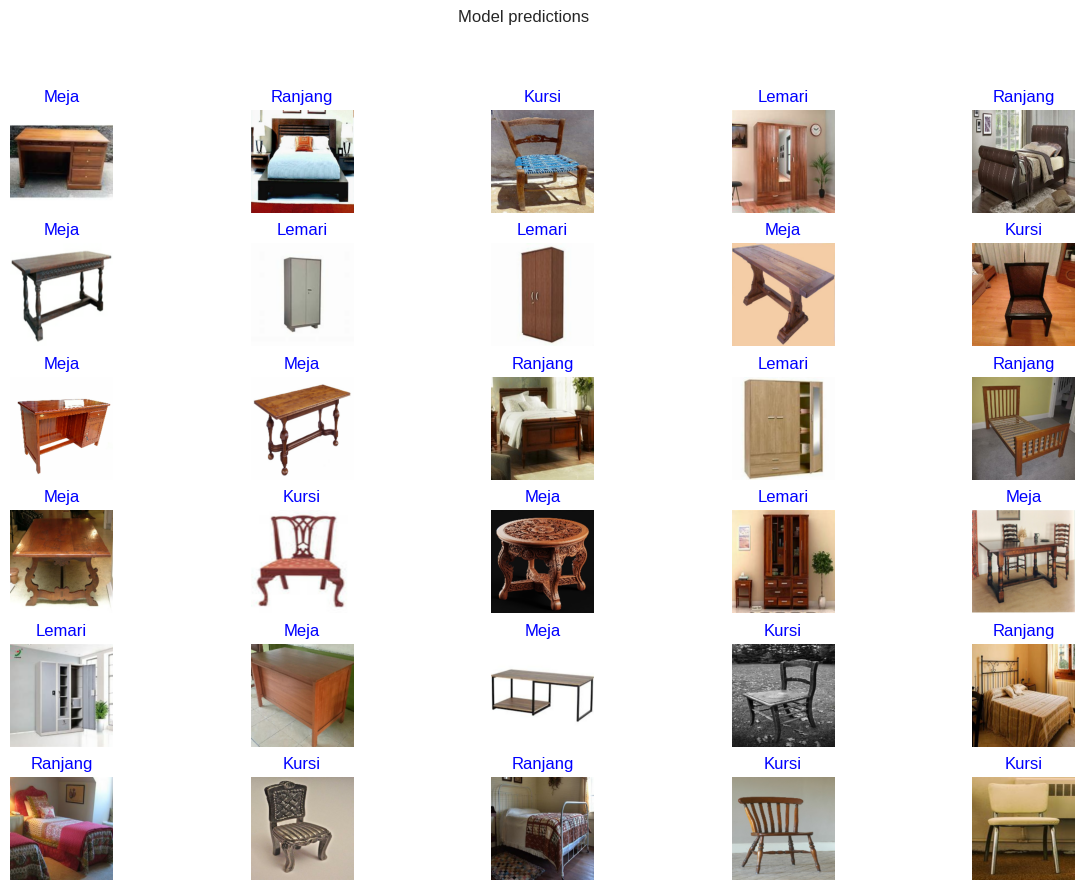

In [32]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n].astype('uint8'))
  color = "blue" if predicted_ids[n] == label_batch_test[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions")

Saving ranjang_ (1).jpg to ranjang_ (1).jpg
1/1 [==============================] - 1s 1s/step
ranjang_ (1).jpg
ranjang
[[2.886557e-07 5.134034e-10 3.597825e-06 9.999962e-01]]
0.9999962


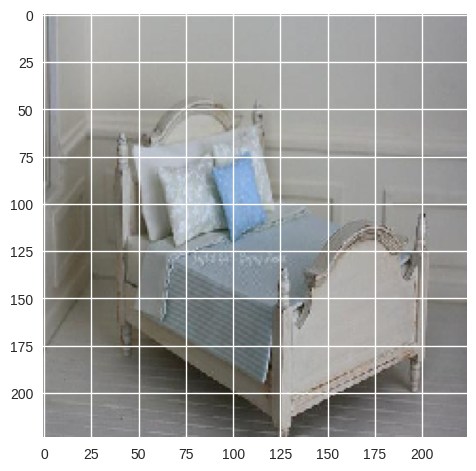

In [33]:
from google.colab import files
import keras.utils as image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size= IMG_SIZE + (3,))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = load_model.predict(images, batch_size=10)
  outclass = np.argmax(classes)

  print(fn)
  plt.imshow(img)
  for i, label in enumerate(class_names):
    if outclass == i:
      predict = classes[0][i]
      print(label)
      print(classes)
      print(predict)

In [34]:
x_test = []
y_test = []

for x_batch, y_batch in test_dataset:
  for x_i, y_i in zip(x_batch, y_batch):
    x_test.append(x_i)
    y_test.append(y_i)

x_test = np.array(x_test)
y_test = np.array(y_test)


# Testing accuracy with the test data
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(x_test), axis=-1)
accuracy = accuracy_score(y_test, pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

3/3 [==============================] - 1s 50ms/step
Accuracy: 97.92%


In [35]:
# Calculate metrics for classification
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       1.00      1.00      1.00        29
           2       0.92      1.00      0.96        22
           3       1.00      0.96      0.98        24

    accuracy                           0.98        96
   macro avg       0.98      0.98      0.98        96
weighted avg       0.98      0.98      0.98        96



In [36]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                        

In [37]:
load_model.save('/content/drive/MyDrive/Colab Notebooks/model_furniture.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
!pip install tensorflowjs
!pip install tensorflow=2.15.0

  Using cached tensorflowjs-4.20.0-py3-none-any.whl (89 kB)
  Using cached tensorflow_decision_forests-1.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.5 MB)
  Using cached packaging-23.2-py3-none-any.whl (53 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 113.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Succe

ERROR: Invalid requirement: 'tensorflow=2.15.0'
Hint: = is not a valid operator. Did you mean == ?


In [40]:
path_model = './saved'
output_path = '/content/output_path'
load_model.save(path_model)

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7a6c504efe20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7a6c504efe20>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [41]:
path_model=pathlib.Path(path_model)

In [42]:
!tensorflowjs_converter --input_format=tf_saved_model \
                         --output_node_names='MobilenetV3/Predictions/Reshape_1' \
                         --saved_model_tags=serve \
                         './saved' \
                         output_path

2024-06-22 08:12:35.651994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-22 08:12:38.248390: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [43]:
shutil.make_archive('/content/json', 'zip', output_path)

'/content/json.zip'

In [44]:

from google.colab import files

checkpoint_model_path = './checkpoint_model.h5'
checkpoint_model_path = pathlib.Path(checkpoint_model_path)
files.download('/content/json.zip')
files.download(checkpoint_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>